In [6]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import median_filter
from sklearn.model_selection import train_test_split
import warnings
import logging
from tqdm import tqdm
from keras.layers import Input, Conv1D, Conv2D, MaxPooling2D, concatenate, Dense, Activation, Dropout
from tensorflow.keras.layers import Input, Conv1D, Activation, BatchNormalization, MaxPooling1D, GlobalAveragePooling1D, AveragePooling1D, Dense, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from onevsallhelper import *
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

seed = 42

2.10.0


In [7]:
training_labels = {
    "Wish": 0,
    "Another": 1,
    "Comfortably": 2,
    "Money": 3,
    "Breathe": 4,
    "Time": 5,
    "Brain": 6,
    "Echoes": 7,
    "Wearing": 8,
    "Sorrow": 9,
    "Hey": 10,
    "Shine": 11,
}

### DATA PREPARATION

In [8]:
data = np.load("../../data/x_train.npy")
target = np.load("../../data/y_train.npy")

In [9]:
#SHUFFLE DATA
np.random.seed(42)
p = np.random.permutation(data.shape[0])
data = data[p]
target = target[p]

In [10]:
data[0].shape

(36, 6)

# SPLIT DATA INTO TRAIN / TEST
- Split data into Train and test seqeuences using sequence ID
- We also convert target into OneHotEncoding
- Normalize Data using MinMax Scaler


In [11]:
test_split = 0.2
val_split = 0.1
#OneHotEncoding
target = tfk.utils.to_categorical(target)

#Split Train Test
x_train,x_test,y_train,y_test = train_test_split(data,target, test_size=test_split,random_state=42,stratify=target)
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train, test_size=val_split,random_state=42,stratify=y_train)
x_train.shape,x_test.shape,x_val.shape

((1748, 36, 6), (486, 36, 6), (195, 36, 6))

In [12]:
def normalize_single_series(data):
  for i in tqdm(range(0,data.shape[0])):
    chunck = data[i]
    mean = np.mean(chunck)
    std  = np.std(chunck)
    data[i] = (chunck - mean) / std
  return data


In [13]:
x_old = x_train.copy()
x_train = normalize_single_series(x_train)
x_test  = normalize_single_series(x_test)
x_val   = normalize_single_series(x_val)

x_train.shape

100%|██████████| 195/195 [00:00<00:00, 54869.80it/s]


(1748, 36, 6)

In [14]:
def add_noise(seq,weight=0.005):
  #Copy Data
  seq = np.array(seq)
  seq = seq.copy()
  #Calculate STD
  std = np.std(seq) * weight
  #Calculate Mean of this sequence
  noise = np.random.normal(0,std,seq.shape)

  data_augmented = seq + noise*0.1
  return data_augmented

In [15]:
augmentation = True #NOW IS FALSE SINCE IS TO CORRECT THE WAY IT ADD NOISE
np.random.seed(60)

y_new = y_train.copy()
x_new = x_train.copy()
if augmentation:
  weights = [0.01,0.02,0.03, 0.04,0.05, 0.06]
  for w in weights:
    for i in tqdm(range(0,x_train.shape[0])):
      aug = add_noise(x_train[i],w)
      aug = np.expand_dims(aug, axis=0)
      #print(aug.shape,x_new.shape)
      #print(y_new.shape,y_train.shape)
      x_new    = np.vstack([x_new,aug])
      y_new    = np.vstack([y_new,y_train[i]])

x_train_aug1  = x_new
y_train_aug1  = y_new
x_train.shape,y_train.shape, x_train_aug1.shape, y_train_aug1.shape

100%|██████████| 1748/1748 [00:03<00:00, 473.82it/s]


((1748, 36, 6), (1748, 12), (12236, 36, 6), (12236, 12))

In [16]:
import utils.augmentation as aug

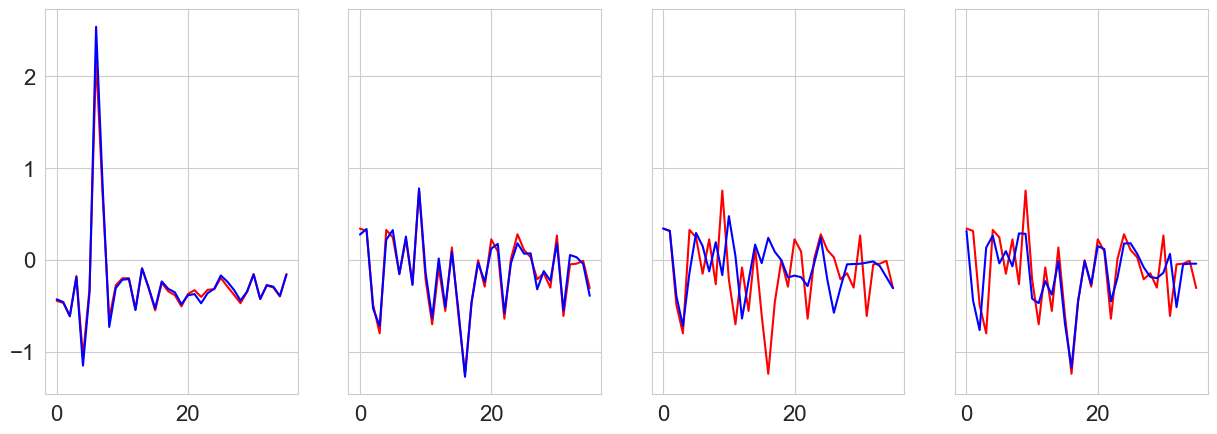

In [17]:
fig, ax =  plt.subplots(1, 4, figsize=(15, 5), sharey=True)

ax[0].plot(x_train[0, :, 0], color="red")
ax[0].plot(aug.magnitude_warp(x_train, sigma=0.1, knot=10)[0, :, 0], color="blue")

ax[1].plot(x_train[2, :, 0], color="red")
ax[1].plot(aug.jitter(x_train, sigma=0.06)[2, :, 0], color="blue")

ax[2].plot(x_train[2, :, 0], color="red")
ax[2].plot(aug.time_warp(x_train)[2, :, 0], color="blue")

ax[3].plot(x_train[2, :, 0], color="red")
ax[3].plot(aug.window_slice(x_train)[2, :, 0], color="blue")

plt.show()

In [18]:
x_train = np.append(x_train, aug.jitter(x_train, sigma=0.06)[:3000], axis=0)
y_train = np.append(y_train, y_train[:3000], axis=0)
x_train = np.append(x_train, aug.magnitude_warp(x_train, sigma=0.1, knot=10)[:3000], axis=0)
y_train = np.append(y_train, y_train[:3000], axis=0)
x_train = np.append(x_train, aug.time_warp(x_train)[:3000], axis=0)
y_train = np.append(y_train, y_train[:3000], axis=0)
x_train = np.append(x_train, aug.window_slice(x_train)[:3000], axis=0)
y_train = np.append(y_train, y_train[:3000], axis=0)

x_train = np.append(x_train, x_train_aug1, axis=0)
y_train = np.append(y_train, y_train_aug1, axis=0)


indexes = np.random.choice(x_train.shape[0], x_train.shape[0])
x_train = x_train[indexes]
y_train = y_train[indexes]

In [19]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [20]:
x_n_classes = []
y_n_classes = []
i = 0
sample_non_class = np.where(y_train[:, i] == 0)[0]
sample_class = np.where(y_train[:, i] == 1)[0]
sample_non_class = sample_non_class[np.random.choice(sample_non_class.shape[0], sample_class.shape[0])]
sample_indexes = np.append(sample_class, sample_non_class)
np.random.shuffle(sample_indexes)
x_n_classes.append(x_train[sample_indexes])

y_class = y_train[sample_indexes, i]
y_class = np.c_[y_class, np.logical_not(y_class)]
y_n_classes.append(y_class)

In [39]:
def convert_to_n_classes(x_train, y_train, n_classes):
    """
    Converts the dataset x_train, y_train in n_classes datasets
    where each y_train in 1 if the class is the one of the dataset, 0 otherwise.
    """
    x_n_classes = []
    y_n_classes = []
    for i in range(n_classes):
        sample_non_class = np.where(y_train[:, i] == 0)[0]
        sample_class = np.where(y_train[:, i] == 1)[0]
        sample_non_class = sample_non_class[np.random.choice(sample_non_class.shape[0], 3*sample_class.shape[0])]
        sample_indexes = np.append(sample_class, sample_non_class)
        np.random.shuffle(sample_indexes)
        x_n_classes.append(x_train[sample_indexes])

        y_class = y_train[sample_indexes, i]
        y_class = np.c_[y_class, np.logical_not(y_class)]
        y_n_classes.append(y_class)
    return np.array(x_n_classes), np.array(y_n_classes)


In [49]:
x_train_list, y_train_list = convert_to_n_classes(x_train, y_train, y_train.shape[-1])
x_val_list, y_val_list = convert_to_n_classes(x_val, y_val, y_train.shape[-1])
x_test_list, y_test_list =  convert_to_n_classes(x_test, y_test, y_test.shape[-1])

/var/folders/0y/xb7crskj6j96cb2cmd4bsvm00000gn/T/ipykernel_53214/2230591363.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(x_n_classes), np.array(y_n_classes)


now we train n_classes models and then we ensemble them

In [60]:
x_train_list[9].shape, y_train_list[9].shape

((31520, 36, 6), (31520, 2))

In [42]:
x_val_list[2].shape, y_val_list[2].shape

((88, 36, 6), (88, 2))

# NOW USE THE GENERATED TIME SERIES TO TRAIN OUR MODELS

Vanilla Attempts:
-CNN1D :

In [43]:
input_shape = x_train_list[0].shape[1:]
classes = y_train_list[0].shape[-1]
batch_size = 128
epochs = 200

In [44]:
input_shape, classes

((36, 6), 2)

# Build and run model


In [45]:
# build a network to classify data series with Conv1D
def build_4_layers_conv1d_network(input_shape, classes, learning_rate=0.001, momentum=0.9, loss="binary_crossentropy",
                                  metrics=["accuracy"]):
    """
    Builds 4 layers Conv1D network for data series.
    """
    # Define the model input
    input = Input(shape=input_shape)


    # # Apply convolutional layers
    x = tfkl.Conv1D(filters=32, kernel_size=7, strides=1, padding="same")(input)
    x = tfkl.Activation("sigmoid")(x)

    x = tfkl.Conv1D(filters=64, kernel_size=5, strides=1, padding="same")(x)
    x = tfkl.Activation("sigmoid")(x)

    x = tfkl.Dense(units=128)(x)
    x = tfkl.Activation("sigmoid")(x)
    x = tfkl.BatchNormalization()(x)

    x = tfkl.Conv1D(filters=128, kernel_size=3, strides=1, padding="same")(x)
    x = tfkl.Activation("sigmoid")(x)

    x = tfkl.Dense(units=256)(x)
    x = tfkl.Activation("sigmoid")(x)
    x = tfkl.BatchNormalization()(x)

    x = tfkl.Conv1D(filters=256, kernel_size=1, strides=1, padding="same")(x)
    x = tfkl.Activation("sigmoid")(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.MaxPooling1D(pool_size=2)(x)
    x = tfkl.GlobalAveragePooling1D()(x)

    x = tfkl.Flatten()(x)
    x = tfkl.Dense(units=512)(x)
    x = tfkl.Dropout(0.5)(x)


    x = tfkl.Dense(units=2)(x)
    x = tfkl.Activation("softmax")(x)

    # Define the model
    model = Model(inputs=input, outputs=x)

    # Compile the model
    model.compile(optimizer=SGD(learning_rate=learning_rate, momentum=momentum), loss=loss, metrics=metrics)

    return model

model = build_4_layers_conv1d_network(input_shape, classes)
model.summary()
# tfk.utils.plot_model(model)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 36, 6)]           0         
                                                                 
 conv1d_8 (Conv1D)           (None, 36, 32)            1376      
                                                                 
 activation_14 (Activation)  (None, 36, 32)            0         
                                                                 
 conv1d_9 (Conv1D)           (None, 36, 64)            10304     
                                                                 
 activation_15 (Activation)  (None, 36, 64)            0         
                                                                 
 dense_9 (Dense)             (None, 36, 128)           8320      
                                                                 
 activation_16 (Activation)  (None, 36, 128)           0   

In [61]:
# model = tf.keras.models.load_model("modello_a_caso")
# Train the model
history = model.fit(
    x=x_train_list[9],
    y=y_train_list[9],
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val_list[9], y_val_list[9]),
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
247/247 [==============================] - 6s 26ms/step - loss: 0.5981 - accuracy: 0.7392 - val_loss: 0.6130 - val_accuracy: 0.7500 - lr: 1.0000e-05
Epoch 2/200
247/247 [==============================] - 6s 23ms/step - loss: 0.5921 - accuracy: 0.7439 - val_loss: 0.5675 - val_accuracy: 0.7500 - lr: 1.0000e-05
Epoch 3/200
247/247 [==============================] - 6s 24ms/step - loss: 0.5857 - accuracy: 0.7452 - val_loss: 0.5619 - val_accuracy: 0.7500 - lr: 1.0000e-05
Epoch 4/200
247/247 [==============================] - 6s 23ms/step - loss: 0.5816 - accuracy: 0.7467 - val_loss: 0.5584 - val_accuracy: 0.7500 - lr: 1.0000e-05
Epoch 5/200
247/247 [==============================] - 6s 23ms/step - loss: 0.5787 - accuracy: 0.7483 - val_loss: 0.5553 - val_accuracy: 0.7500 - lr: 1.0000e-05
Epoch 6/200
247/247 [==============================] - 6s 24ms/step - loss: 0.5751 - accuracy: 0.7481 - val_loss: 0.5526 - val_accuracy: 0.7500 - lr: 1.0000e-05
Epoch 7/200
247/247 [=============

In [68]:

# Predict the test set with the model
predictions = model.predict(x_test_list[9])
predictions

20/20 [==============================] - 0s 8ms/step


array([[0.2731183 , 0.7268817 ],
       [0.2745266 , 0.72547346],
       [0.3749076 , 0.6250924 ],
       ...,
       [0.33763173, 0.6623683 ],
       [0.3629637 , 0.63703626],
       [0.31438646, 0.6856136 ]], dtype=float32)

Accuracy: 0.7371
Precision: 0.3734
Recall: 0.4914
F1: 0.4243


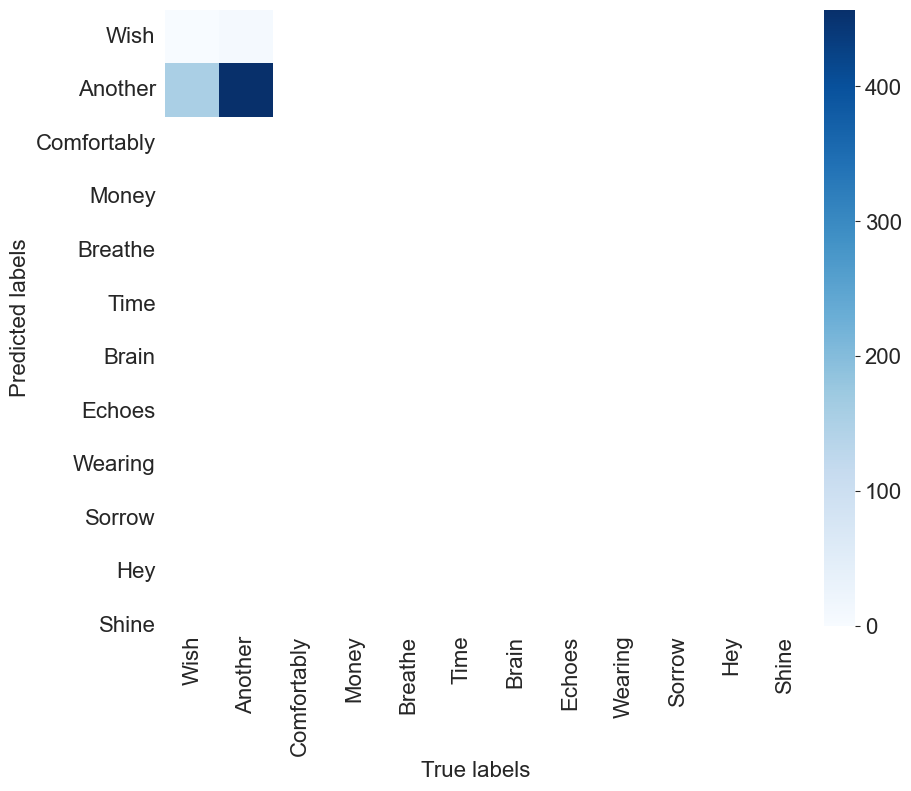

In [64]:
cm = confusion_matrix(np.argmax(y_test_list[9], axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test_list[9], axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test_list[9], axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test_list[9], axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test_list[9], axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(training_labels.keys()), yticklabels=list(training_labels.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()